### Spring shooting example
This notebook contains the example to use the implemented spring shooting algorithm to run a TPS simulation. It is mainly build from the toy example of OPS

### First start with the imports

In [1]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import matplotlib.pyplot as plt
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG
import openpathsampling.engines.toy as toys
import numpy as np
from openpathsampling import SpringShootingMoveScheme

# Some magic to get the toy_plot_helpers of OPS. This works if 
# openpathsampling is installed from github with 'pip install -e .'
# otherwise download the toy_plot_helpers.py from 
# https://raw.githubusercontent.com/openpathsampling/openpathsampling/master/examples/resources/toy_plot_helpers.py

ops_dir = paths.__file__.rsplit('/',2)[0]
plot_helper = ops_dir+'/examples/resources/toy_plot_helpers.py'
%run $plot_helper

### Make the potential energy surface

In [2]:
# always the most complicated bit

pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-1.0, [12.0, 0.5], [-0.6, 0.0]) +
       toys.Gaussian(-1.0, [12.0, 0.5], [0.6, 0.0]))
topology = toys.Topology(n_spatial=2, masses=[1.0], pes=pes)
engine = toys.Engine({'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 100,
                              'n_steps_per_frame': 5}, topology)
template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

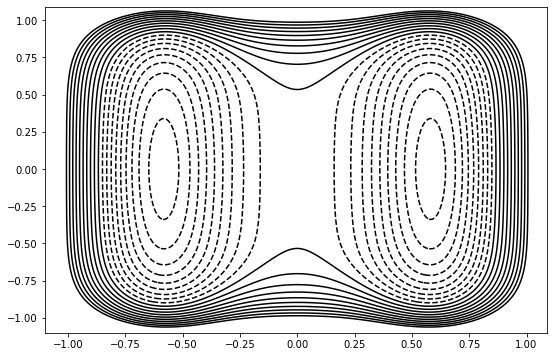

In [3]:
plot = ToyPlot()
plot.contour_range = np.arange(-1.5, 1.0, 0.1)
plot.add_pes(pes)
fig = plot.plot()

### Build the TPS Network

In [4]:
def xval(snapshot):
    return snapshot.xyz[0][0]

# Define cv
cv = paths.FunctionCV("xval", xval)
cv.enable_diskcache()
# Define states
stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.6).named("A")
stateB = paths.CVDefinedVolume(cv, 0.6, float("inf")).named("B")

# Build the network
network = paths.TPSNetwork(stateA, stateB)

### Define the moveschemes
Here we define both the spring shooting and the regular one way shooting scheme

In [5]:
spring_scheme=SpringShootingMoveScheme(network=network, 
                                       delta_max=5, 
                                       k_spring=0.5, 
                                       engine=engine,
                                       initial_guess=None)
uniform_scheme= paths.OneWayShootingMoveScheme(network, engine=engine)

### Initialize the moveschemes

In [6]:
trajectory = paths.Trajectory([
    toys.Snapshot(coordinates=np.array([[-.75+k*0.1, 0.0]]),
                  velocities=np.array([[0.1, 0.0]]),
                  engine=engine)
    for k in range(15)
])

spring_initial_conditions = spring_scheme.initial_conditions_from_trajectories(trajectory)
uniform_initial_conditions = uniform_scheme.initial_conditions_from_trajectories(trajectory)

No missing ensembles.
No extra ensembles.


### Open the storages and make the simulation objects

In [7]:
spring_storage = paths.Storage("spring_test2D.nc", "w", template=template)
uniform_storage = paths.Storage("uniform_toy2D.nc", 'w', template=template)
spring_simulation = paths.PathSampling(spring_storage, spring_scheme, spring_initial_conditions)
uniform_simulation = paths.PathSampling(uniform_storage, uniform_scheme, uniform_initial_conditions)

### Run the simulations

In [8]:
simulation_steps = 1000
spring_simulation.run(simulation_steps)

Working on Monte Carlo cycle number 1000
Running for 1 minute 14 seconds -  0.07 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 1000 Monte Carlo cycles.


In [9]:
uniform_simulation.run(simulation_steps)

Working on Monte Carlo cycle number 1000
Running for 1 minute 1 second -  0.06 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 1000 Monte Carlo cycles.


### Take a look at the PathThrees

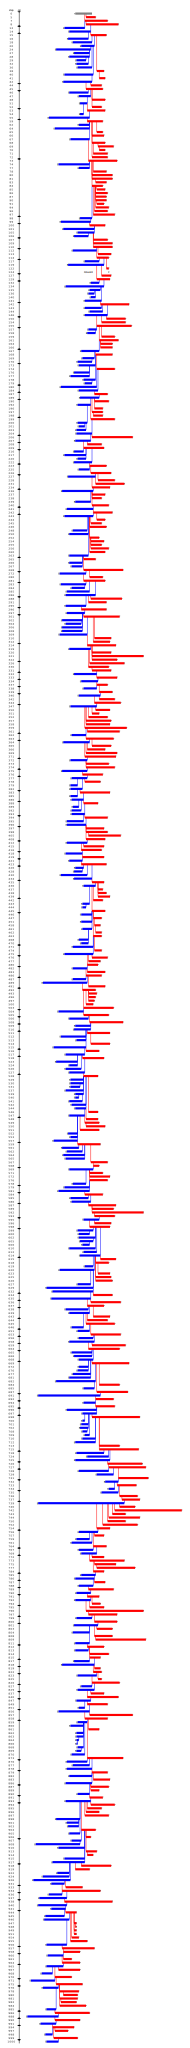

In [10]:
sstree = ops_vis.PathTree(
    spring_storage.steps[:],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
# Needed to update the colouring.
sstree.options.movers.update({
                              'BackwardSpringMover': {'name': 'Backward',
                                                      'suffix': 'b',
                                                      'css_class': ['shooting']
                                                      },
                              'ForwardSpringMover': {'name': 'Forward',
                                                     'suffix': 'f',
                                                     'label_position': 'right',
                                                     'css_class': ['shooting']
                                                    }
                                })
decorrelated_trajs = [sample.trajectory for sample in sstree.generator.decorrelated]
SVG(sstree.svg())

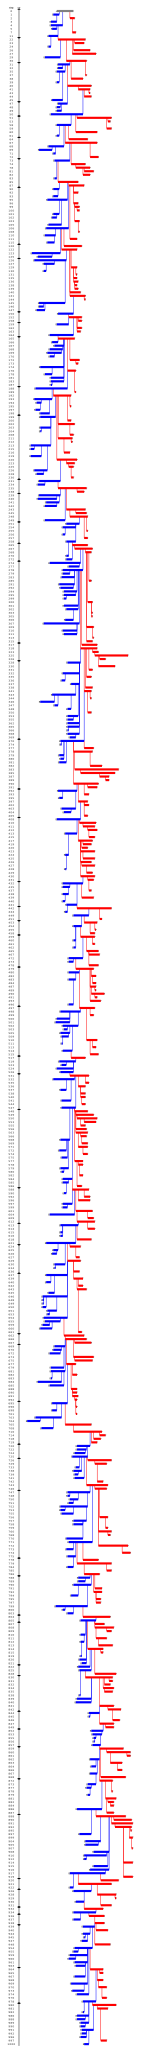

In [11]:
import openpathsampling.visualize as ops_vis
utree = ops_vis.PathTree(
    uniform_storage.steps[:],
    ops_vis.ReplicaEvolution(
        replica=0,
        accepted=True
    )
)
decorrelated_trajs = [sample.trajectory for sample in utree.generator.decorrelated]
SVG(utree.svg())


### Print the amount of decorrelated trajectories

In [12]:
print ("Spring Shooting decorrelated trajectories:", len(sstree.generator.decorrelated_trajectories))
print ("Uniform Shooting decorrelated trajectories:", len(utree.generator.decorrelated_trajectories))

Spring Shooting decorrelated trajectories: 140
Uniform Shooting decorrelated trajectories: 62


### Compare the pathlengths

Spring:
Maximum: 120 (12.0)
Average: 33.651349
Uniform:
Maximum: 54 (5.4)
Average: 27.966034


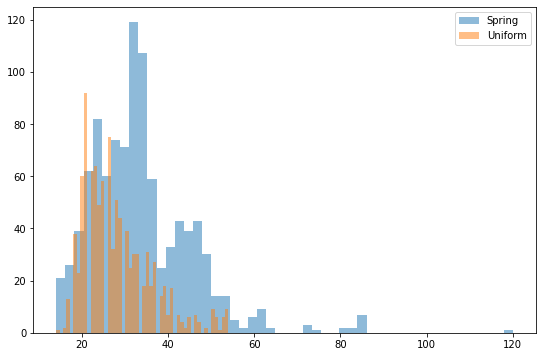

In [13]:
for storage in  [spring_storage, uniform_storage]:
    path_lengths = [len(step.active[0].trajectory) for step in storage.steps[:]]
    if storage is spring_storage:
        name = 'Spring'
    elif storage is uniform_storage:
        name = 'Uniform'
    plt.hist(path_lengths, bins=50, alpha=0.5, label=name);
    
    print(name+':')
    print("Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")")
    print("Average:", "{0:1f}".format(np.mean(path_lengths)))
plt.legend()

In [14]:
# Colour function to make pretty pictures!
def make_rainbow(length):
    color_step = 5.0/(length)
    r,g,b = (1,0,0)
    color_range = 0
    colors = []
    for i in range(length):
        if color_range == 0:
            g += color_step
            if g >= 1.0:
                g = 1.0
                color_range += 1
        elif color_range == 1:
            r -= color_step
            if r <= 0:
                r = 0.0
                color_range +=1
        elif color_range == 2:
            b += color_step
            if b >= 1:
                b = 1.0
                color_range +=1
        elif color_range == 3:
            g -= color_step
            if g <= 0:
                g = 0
                color_range +=1
        elif color_range == 4:
            r += color_step
            if r >= 1:
                r = 1
                color_range +=1
        colors.append((r,g,b))
    return colors

### Plot the selected shooting points

this plots the selected shooting points on the potential energy surface, coloured based on step number

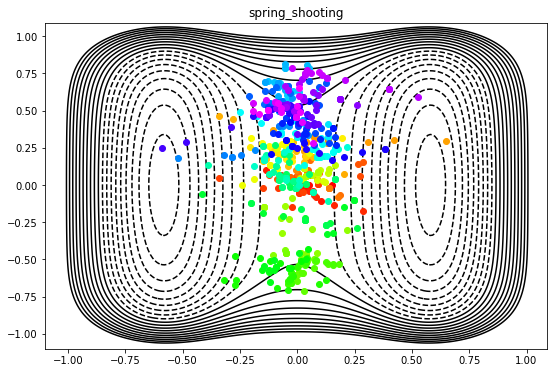

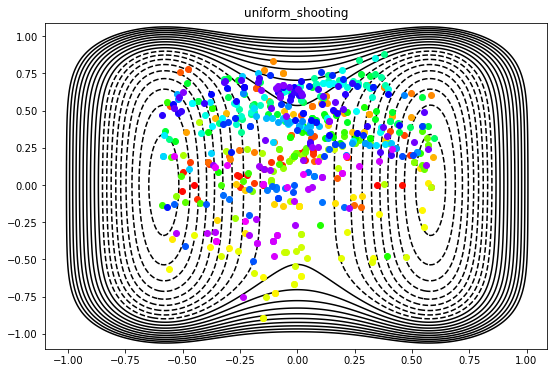

In [15]:
for storage in [spring_storage, uniform_storage]:
    plot = ToyPlot()
    plot.contour_range = np.arange(-1.5, 1.0, 0.1)
    plot.add_pes(pes)
    fig = plot.plot()
    x_shooting_points = []
    y_shooting_points = []
    for step in storage.steps[1:]:
        if step.change.accepted:
            shooting_point = step.change.canonical.details.shooting_snapshot
            x_shooting_points.append(shooting_point.xyz[0][0])
            y_shooting_points.append(shooting_point.xyz[0][1])

    colors = make_rainbow(len(x_shooting_points))
    for i in range(len(x_shooting_points)):
        plt.plot(x_shooting_points[i], y_shooting_points[i], 'o', color = colors[i])
    if storage is spring_storage:
        title = 'spring_shooting'
    if storage is uniform_storage:
        title = 'uniform_shooting'
    plt.title(title)
    plt.show()

In [16]:
spring_storage.sync()
uniform_storage.sync()
spring_storage.close()
uniform_storage.close()

### Restarting a simulation needs an extra step 
Because the selector needs to know about its history, you will need to also restart the selector

In [17]:
#To restart a simulation, an extra step is needed.

#Restart calculation
load_spring_storage = paths.Storage("spring_test2D.nc",'a')
test_calc = load_spring_storage.pathsimulators[0]
test_calc.restart_at_step(load_spring_storage.steps[-1])

#Restart the selector
test_calc.root_mover[0][0].selector.restart_from_step(load_spring_storage.steps[-1])

#Now the simulation can run correctly
test_calc.run(1)

Working on Monte Carlo cycle number 1001
Starting simulation...
Working on first step
DONE! Completed 1001 Monte Carlo cycles.
